In [1]:
# Geopandas for Geoplotting
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas

In [2]:
# set directory
import os
os.chdir(r'C:/Users/2xu2/International_trade/data')

## Import data

In [3]:
# Data processed from import analysis
industrytariff = pd.read_csv('outputdata/NAICS4_industry_import.csv', index_col = 0)
industrytariff.date = pd.to_datetime(industrytariff.date)
industrytariff.NAICS4 = industrytariff.NAICS4.astype(int)
industrytariff.head()

,NAICS4,date,china_import,total_import,weighted_tariff,emplvl,total_china_import,NAICS2,treatment
0,1111,2016-01-01,9351822.0,271853483.0,0.501397,46879,268111471.0,11,0
1,1111,2016-02-01,6817036.0,217027631.0,0.501397,47328,268111471.0,11,0
2,1111,2016-03-01,7240204.0,301227559.0,0.501397,49197,268111471.0,11,0
3,1111,2016-04-01,5832994.0,262957341.0,0.501397,53431,268111471.0,11,0
4,1111,2016-05-01,6601558.0,213649478.0,0.501397,55389,268111471.0,11,0


In [4]:
# first get NAICS4 level industry employment in 2017
NAICS4_industry2017 = industrytariff[(industrytariff['date'] >= pd.Timestamp(2017,1,1))&
                                     (industrytariff['date'] <= pd.Timestamp(2017,12,1))]
NAICS4_emp_2017 = NAICS4_industry2017.groupby('NAICS4')['emplvl'].sum()
NAICS4_emp_2017 = NAICS4_emp_2017.reset_index()
NAICS4_emp_2017['NAICS2'] = NAICS4_emp_2017.NAICS4.astype(str).str[:-2].astype(int)
NAICS4_emp_2017.head()

,NAICS4,emplvl,NAICS2
0,1111,661233,11
1,1112,1140267,11
2,1113,2268001,11
3,1114,1833820,11
4,1119,756602,11


In [5]:
# get the NAICS2 employment data to calculate the ratio
NAICS2_emp_2017 = NAICS4_industry2017.groupby('NAICS2')['emplvl'].sum().reset_index()
NAICS2_emp_2017 = NAICS2_emp_2017.rename({'emplvl':'emplvlNAICS2'}, axis = 1)
NAICS4_emp_2017 = pd.merge(NAICS4_emp_2017, NAICS2_emp_2017,
                           how = "left",
                           left_on = "NAICS2",
                           right_on = "NAICS2")
NAICS4_emp_2017['emp_ratio_2017'] = NAICS4_emp_2017['emplvl']/NAICS4_emp_2017['emplvlNAICS2']
NAICS4_emp_ratio = NAICS4_emp_2017.drop(['emplvlNAICS2'], axis = 1)
NAICS4_emp_ratio.head()

,NAICS4,emplvl,NAICS2,emp_ratio_2017
0,1111,661233,11,0.043687
1,1112,1140267,11,0.075336
2,1113,2268001,11,0.149844
3,1114,1833820,11,0.121158
4,1119,756602,11,0.049988


In [6]:
# Get the industry weighted tariff change from Jan2018 to Dec2019
subsample = industrytariff[(industrytariff['date'] == pd.Timestamp(2018, 1, 1))|
                            (industrytariff['date'] == pd.Timestamp(2019, 12, 1))]

# Shift to calculate difference in tariff
subsample['tariff2018Jan'] = subsample.groupby('NAICS4')['weighted_tariff'].shift()

# Only keep shifted data to calculate exposure change
subsample = subsample[subsample['date'] == pd.Timestamp(2019, 12, 1)]
subsample['tariffchange'] = subsample['weighted_tariff'] - subsample['tariff2018Jan']

# Keep the desired columns
subsample = subsample[['NAICS4', 'tariffchange']]

# Naics2 industry level

subsample['NAICS2'] = subsample.NAICS4.astype(str).str[:-2]
subsample.NAICS2 = subsample.NAICS2.astype(int)
subsample.head()

C:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,NAICS4,tariffchange,NAICS2
47,1111,23.332999,11
97,1112,19.643774,11
147,1113,18.731516,11
197,1114,15.063321,11
247,1119,21.858282,11


In [7]:
# Bring in NAICS2 industry discriptions
# Only contains descriptions of industry with trade
NAICS2description_import = pd.read_excel('NAICS2_import_description.xlsx', header = 0)

# markers and color for plots
NAICS2description_import['marker'] = ["v",  "h", "*", "p"]
NAICS2description_import['color'] = ['green', 'orange', 'navy', 'crimson']

NAICS4plot_import = pd.merge(subsample, NAICS2description_import,
                      how = "left",
                      left_on = "NAICS2",
                      right_on = "NAICS2").dropna()

NAICS4plot_import.head( )

,NAICS4,tariffchange,NAICS2,Industry,marker,color
0,1111,23.332999,11,"Agriculture, Forestry, Fishing and Hunting",v,green
1,1112,19.643774,11,"Agriculture, Forestry, Fishing and Hunting",v,green
2,1113,18.731516,11,"Agriculture, Forestry, Fishing and Hunting",v,green
3,1114,15.063321,11,"Agriculture, Forestry, Fishing and Hunting",v,green
4,1119,21.858282,11,"Agriculture, Forestry, Fishing and Hunting",v,green


In [8]:
# Merge with employment data
NAICS4plot_import = pd.merge(NAICS4plot_import, NAICS4_emp_ratio[['NAICS4', 'emplvl', 'emp_ratio_2017']],
                         how = "left", 
                         left_on = "NAICS4",
                         right_on = "NAICS4")
NAICS4plot_import = NAICS4plot_import.set_index('NAICS2')
NAICS2description_import = NAICS2description_import.set_index('NAICS2')
NAICS4plot_import.head()

,NAICS4,tariffchange,Industry,marker,color,emplvl,emp_ratio_2017
NAICS2,,,,,,,
11,1111,23.332999,"Agriculture, Forestry, Fishing and Hunting",v,green,661233,0.043687
11,1112,19.643774,"Agriculture, Forestry, Fishing and Hunting",v,green,1140267,0.075336
11,1113,18.731516,"Agriculture, Forestry, Fishing and Hunting",v,green,2268001,0.149844
11,1114,15.063321,"Agriculture, Forestry, Fishing and Hunting",v,green,1833820,0.121158
11,1119,21.858282,"Agriculture, Forestry, Fishing and Hunting",v,green,756602,0.049988


In [9]:
NAICS4plot_import.index.drop_duplicates()

Int64Index([11, 31, 32, 33], dtype='int64', name='NAICS2')

## Export data

In [10]:
NAICS4_industry = pd.read_csv('outputdata/NAICS4_industry_export.csv', index_col = 0)
NAICS4_industry.date = pd.to_datetime(NAICS4_industry.date)
NAICS4_industry.head()

,NAICS4,emplvl,date,NAICS2,china_trade,total_export,weighted_tariff,total_china_export,treatment
0,1111,46879,2016-01-01,11,1.535118e+09,3.356244e+09,5.243654,4.225879e+10,0.0
1,1111,47328,2016-02-01,11,1.246306e+09,3.336276e+09,5.243654,4.225879e+10,0.0
2,1111,49197,2016-03-01,11,5.278442e+08,2.582819e+09,5.243654,4.225879e+10,0.0
3,1111,53431,2016-04-01,11,1.736375e+08,2.178300e+09,5.243654,4.225879e+10,0.0
4,1111,55389,2016-05-01,11,7.824786e+07,1.819935e+09,5.243654,4.225879e+10,0.0


In [11]:
yearlydata = NAICS4_industry.set_index(['date']).groupby('NAICS4')['china_trade'].resample('Y').sum().reset_index()
yearlydata = yearlydata[yearlydata['date'] == pd.Timestamp(2017,12,31)]
yearlydata = yearlydata[yearlydata['china_trade'] > 0].rename({'date':'indicator'}, axis = 1).drop('china_trade', axis = 1)
NAICS4_industry = pd.merge(NAICS4_industry, yearlydata, 
                           how = "left",
                           left_on = "NAICS4",
                           right_on = "NAICS4")
NAICS4_industry = NAICS4_industry.dropna().drop('indicator', axis = 1)

In [12]:
# first get NAICS4 level industry employment in 2017
NAICS4_industry2017 = NAICS4_industry[(NAICS4_industry['date'] >= pd.Timestamp(2017,1,1))&
                                          (NAICS4_industry['date'] <= pd.Timestamp(2017,12,1))]
NAICS4_emp_2017 = NAICS4_industry2017.groupby('NAICS4')['emplvl'].sum()
NAICS4_emp_2017 = NAICS4_emp_2017.reset_index()
NAICS4_emp_2017['NAICS2'] = NAICS4_emp_2017.NAICS4.astype(str).str[:-2].astype(int)
NAICS4_emp_2017.head()

,NAICS4,emplvl,NAICS2
0,1111,661233,11
1,1112,1140267,11
2,1113,2268001,11
3,1114,1833820,11
4,1119,756602,11


In [13]:
# get the NAICS2 employment data to calculate the ratio
NAICS2_emp_2017 = NAICS4_industry2017.groupby('NAICS2')['emplvl'].sum().reset_index()
NAICS2_emp_2017 = NAICS2_emp_2017.rename({'emplvl':'emplvlNAICS2'}, axis = 1)
NAICS4_emp_2017 = pd.merge(NAICS4_emp_2017, NAICS2_emp_2017,
                           how = "left",
                           left_on = "NAICS2",
                           right_on = "NAICS2")
NAICS4_emp_2017['emp_ratio_2017'] = NAICS4_emp_2017['emplvl']/NAICS4_emp_2017['emplvlNAICS2']
NAICS4_emp_ratio = NAICS4_emp_2017.drop(['emplvlNAICS2'], axis = 1)

In [14]:
# get the interested subsample
NAICS4_tariff = NAICS4_industry[(NAICS4_industry['date'] == pd.Timestamp(2017,1,1)) |
                                (NAICS4_industry['date'] == pd.Timestamp(2018,12,1))]

# this is a cool way to calculate the difference
# I get the idea from ECON 770
NAICS4_tariff = NAICS4_tariff[[
    'NAICS4', 'date', 'weighted_tariff']].set_index([
    'NAICS4','date']).unstack(level = 1)

NAICS4_tariffchange = pd.DataFrame(
    NAICS4_tariff['weighted_tariff']['2018-12-01 00:00:00'] - NAICS4_tariff['weighted_tariff']['2017-01-01 00:00:00'])

NAICS4_tariffchange = NAICS4_tariffchange.rename({0:'tariffchange'}, axis = 1).reset_index()
NAICS4_tariffchange.head()

,NAICS4,tariffchange
0,1111,24.985603
1,1112,9.136004
2,1113,38.509718
3,1114,3.158788
4,1119,22.940879


In [15]:
NAICS4plot_export = pd.merge(NAICS4_emp_ratio, NAICS4_tariffchange,
                      how = 'left',
                      left_on = 'NAICS4',
                      right_on = 'NAICS4')

NAICS4plot_export.head()

,NAICS4,emplvl,NAICS2,emp_ratio_2017,tariffchange
0,1111,661233,11,0.066257,24.985603
1,1112,1140267,11,0.114257,9.136004
2,1113,2268001,11,0.227258,38.509718
3,1114,1833820,11,0.183752,3.158788
4,1119,756602,11,0.075813,22.940879


In [16]:
# Bring in NAICS2 industry discriptions
# Only contains descriptions of industry with trade
NAICS2description_export = pd.read_excel('NAICS2_export_description.xlsx', header = 0)

# markers and color for plots
NAICS2description_export['marker'] = ["v", ".", "h", "*", "p"]
NAICS2description_export['color'] = ['green', 'grey', 'orange', 'navy', 'crimson']
NAICS4plot_export = pd.merge(NAICS4plot_export, NAICS2description_export,
                      how = "left",
                      left_on = "NAICS2",
                      right_on = "NAICS2").dropna()

NAICS4plot_export = NAICS4plot_export.set_index('NAICS2')
## NAICS3_wtrade = NAICS3description[NAICS3description['Sector'].isin([11, 21, 31, 32, 33])]
NAICS2description_export = NAICS2description_export.set_index('NAICS2')

NAICS4plot_export.head( )

,NAICS4,emplvl,emp_ratio_2017,tariffchange,Industry,marker,color
NAICS2,,,,,,,
11,1111,661233,0.066257,24.985603,"Agriculture, Forestry, Fishing and Hunting",v,green
11,1112,1140267,0.114257,9.136004,"Agriculture, Forestry, Fishing and Hunting",v,green
11,1113,2268001,0.227258,38.509718,"Agriculture, Forestry, Fishing and Hunting",v,green
11,1114,1833820,0.183752,3.158788,"Agriculture, Forestry, Fishing and Hunting",v,green
11,1119,756602,0.075813,22.940879,"Agriculture, Forestry, Fishing and Hunting",v,green


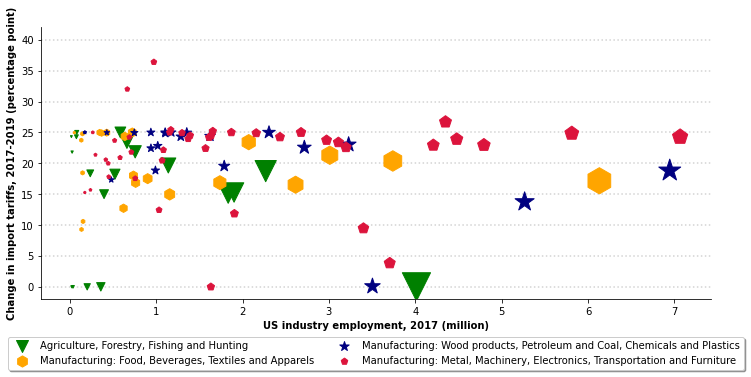

In [17]:
fig, ax = plt.subplots(figsize = (12, 5))

for i in range(0, 45, 5):
    ax.axhline(y = i, linestyle = 'dotted', color = 'lightgrey', zorder= 1)

for i in NAICS4plot_import.index.drop_duplicates():
    scale = NAICS4plot_import.loc[i, 'emp_ratio_2017']*3000
    ax.scatter(NAICS4plot_import.loc[i, 'emplvl']/1000000, 
               NAICS4plot_import.loc[i, 'tariffchange'],
               s = scale, 
               marker = NAICS2description_import.loc[i, 'marker'],
               color  = NAICS2description_import.loc[i, 'color'],
               label = NAICS2description_import.loc[i, 'Industry'], zorder = 2)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=2, fontsize = 10,
          markerscale=0.6)
ax.set_xlabel('US industry employment, 2017 (million)', fontsize = 10, fontweight='bold')
ax.set_ylabel('Change in import tariffs, 2017-2019 (percentage point)', fontsize = 10, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

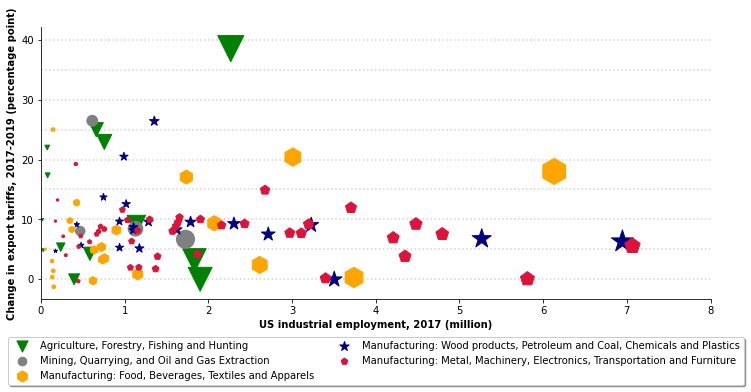

In [18]:
fig, ax = plt.subplots(figsize = (12, 5))

for i in range(0, 45, 5):
    ax.axhline(y = i, linestyle = 'dotted', color = 'lightgrey', zorder= 1)

for i in NAICS4plot_export.index.drop_duplicates():
    scale = NAICS4plot_export.loc[i, 'emp_ratio_2017']*3000
    ax.scatter(NAICS4plot_export.loc[i, 'emplvl']/1000000, 
               NAICS4plot_export.loc[i, 'tariffchange'],
               s = scale, 
               marker = NAICS2description_export.loc[i, 'marker'],
               color  = NAICS2description_export.loc[i, 'color'],
               label = NAICS2description_export.loc[i, 'Industry'], zorder = 2)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=2, fontsize = 10,
          markerscale=0.6)
ax.set_xlabel('US industrial employment, 2017 (million)', fontsize = 10, fontweight='bold')
ax.set_ylabel('Change in export tariffs, 2017-2019 (percentage point)', fontsize = 10, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 8)
plt.savefig('US_export_tariff_change.pdf', bbox_inches='tight')

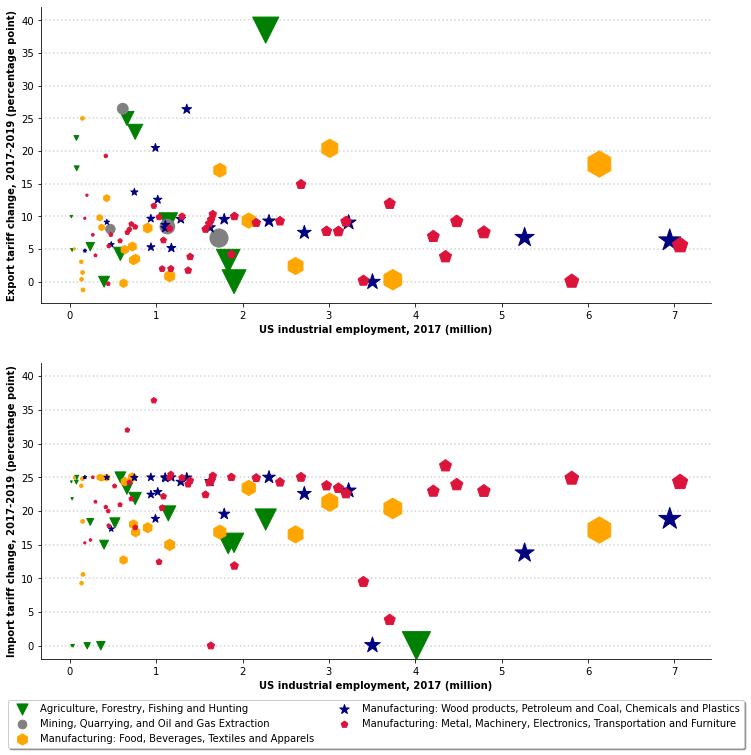

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))

for i in range(0, 45, 5):
    ax[0].axhline(y = i, linestyle = 'dotted', color = 'lightgrey', zorder= 1)

for i in NAICS4plot_export.index.drop_duplicates():
    scale = NAICS4plot_export.loc[i, 'emp_ratio_2017']*3000
    ax[0].scatter(NAICS4plot_export.loc[i, 'emplvl']/1000000, 
               NAICS4plot_export.loc[i, 'tariffchange'],
               s = scale, 
               marker = NAICS2description_export.loc[i, 'marker'],
               color  = NAICS2description_export.loc[i, 'color'],
               label = NAICS2description_export.loc[i, 'Industry'], zorder = 2)
    
ax[0].set_xlabel('US industrial employment, 2017 (million)', fontsize = 10, fontweight='bold')
ax[0].set_ylabel('Export tariff change, 2017-2019 (percentage point)', fontsize = 10, fontweight='bold')
ax[0].set_yticks(range(0, 45, 5))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

for i in range(0, 45, 5):
    ax[1].axhline(y = i, linestyle = 'dotted', color = 'lightgrey', zorder= 1)

for i in NAICS4plot_import.index.drop_duplicates():
    scale = NAICS4plot_import.loc[i, 'emp_ratio_2017']*3000
    ax[1].scatter(NAICS4plot_import.loc[i, 'emplvl']/1000000, 
               NAICS4plot_import.loc[i, 'tariffchange'],
               s = scale, 
               marker = NAICS2description_import.loc[i, 'marker'],
               color  = NAICS2description_import.loc[i, 'color'],
               label = NAICS2description_import.loc[i, 'Industry'], zorder = 2)

ax[1].set_xlabel('US industrial employment, 2017 (million)', fontsize = 10, fontweight='bold')
ax[1].set_ylabel('Import tariff change, 2017-2019 (percentage point)', fontsize = 10, fontweight='bold')
ax[1].set_yticks(range(0, 45, 5))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)


ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -1.32),
          fancybox=True, shadow=True, ncol=2, fontsize = 10,
          markerscale=0.6)
plt.savefig('output_graph/US_industry_joint_tariff_change.pdf', bbox_inches='tight')

## Geoplot for county exposure change

In [3]:
# Data processed from import analysis
countyexposure_import = pd.read_csv('outputdata/countyexposure_import.csv', index_col = 0)
# We just need the exposurechange for geographic plotting here
# Choose any specific time will do the job
im_exp_change = countyexposure_import[countyexposure_import['date'] == '2018-01-01'].drop(['date', 'exposure', 'emplvl', 'group'], axis = 1)
im_exp_change.head()

,area_fips,exposurechange
24,1001,0.326026
74,1003,0.967854
124,1005,0.741519
174,1007,2.299119
224,1009,1.430284


In [4]:
# Data processed from export analysis
countyexposure_export = pd.read_csv('outputdata/countyexposure_export.csv', index_col = 0)
countyexposure_export.date = pd.to_datetime(countyexposure_export.date)
# Get the exposure change for counties from Jan. 2018 to Dec. 2019
ex_exp_change = countyexposure_export[(countyexposure_export['date'] == pd.Timestamp(2018, 1, 1))|
                            (countyexposure_export['date'] == pd.Timestamp(2019, 12, 1))]

# Shift to calculate difference in tariff
ex_exp_change['exposure2018Jan'] = ex_exp_change.groupby('area_fips')['exposure'].shift()

# Only keep shifted data to calculate exposure change
ex_exp_change = ex_exp_change[ex_exp_change['date'] == pd.Timestamp(2019, 12, 1)]
ex_exp_change['ex_exposurechange'] = ex_exp_change['exposure'] - ex_exp_change['exposure2018Jan']

# Keep the desired columns
ex_exp_change = ex_exp_change[['area_fips', 'ex_exposurechange']]

ex_exp_change.head()

C:\anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,area_fips,ex_exposurechange
47,1001,0.294485
98,1003,0.738847
149,1005,0.806419
200,1007,1.793585
251,1009,1.322588


In [5]:
ex_exp_change['ex_exposurechange'].describe()

count    3274.000000
mean        1.428954
std         2.568984
min        -3.273996
25%         0.097532
50%         0.640072
75%         1.603792
max        39.745773
Name: ex_exposurechange, dtype: float64

In [6]:
# Geographic data of US counties from Census Bureau
counties = geopandas.read_file('cb_2018_us_county_500k\cb_2018_us_county_500k.shp')
counties.STATEFP = counties.STATEFP.astype(int)
counties.GEOID = counties.GEOID.astype(int)
# Drop counties outside US mainland to make the plot reasonable
counties = counties.drop(counties.index[counties['STATEFP'].isin([2, 15, 60, 66, 69, 72, 78])])
countyexposurechange = pd.merge(counties, im_exp_change,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on = 'area_fips')
countyexposurechange = pd.merge(countyexposurechange, ex_exp_change,
                          how = 'left',
                          left_on = 'GEOID',
                          right_on = 'area_fips')
countyexposurechange.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,area_fips_x,exposurechange,area_fips_y,ex_exposurechange
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",21007,0.000000,21007,0.000000
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",21017,5.147553,21017,1.282675
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",21031,1.089694,21031,1.166880
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646...",21065,0.000000,21065,0.000000
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",21069,4.220536,21069,3.323623


In [7]:
for i in countyexposurechange.index:
    if countyexposurechange.loc[i, 'ex_exposurechange'] < 0:
        countyexposurechange.loc[i, 'ex_exposurechange'] = 0

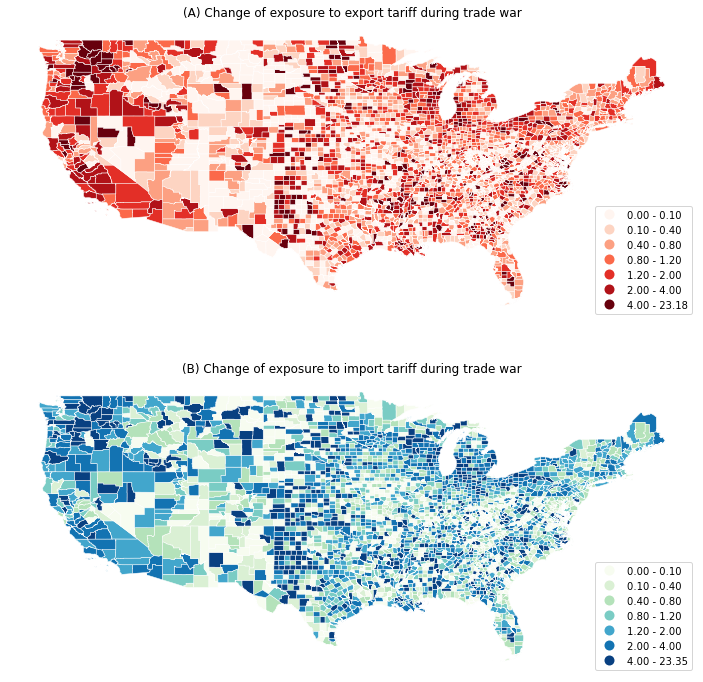

In [8]:
fig, gax = plt.subplots(2, 1, figsize = (40,12))
countyexposurechange.plot(ax=gax[0], edgecolor='white', linewidth = 0.5, 
                          column='ex_exposurechange', 
                          legend=True, legend_kwds={'loc': 'lower right'}, 
                          cmap='Reds', scheme='user_defined', 
                          classification_kwds={'bins':[0.1, 0.4, 0.8, 1.2, 2, 4]})

# Geoplotting
countyexposurechange.plot(ax=gax[1], edgecolor='white', linewidth = 0.5, 
                          column='exposurechange', 
                          legend=True, legend_kwds={'loc': 'lower right'}, 
                          cmap='GnBu', scheme='user_defined', 
                          classification_kwds={'bins':[0.1, 0.4, 0.8, 1.2, 2, 4]})
# Basically the bins are chosen by rounded quantiles
gax[0].set_title('(A) Change of exposure to export tariff during trade war')
gax[1].set_title('(B) Change of exposure to import tariff during trade war')
gax[0].set_axis_off()
gax[1].set_axis_off()
plt.savefig('output_graph/US_county_joint_tariff_change.jpg', bbox_inches='tight')